In [ ]:
!nvidia-smi

Mon Nov 30 02:22:34 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!git clone https://github.com/ken19980727/vae_role.git

Cloning into 'vae_role'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 9 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (9/9), done.


In [ ]:
!unzip /content/vae_role/train.zip

Streaming output truncated to the last 5000 lines.
  inflating: train_vae/img/dart4_4.png  
  inflating: train_vae/img/dart3_1.png  
  inflating: train_vae/img/seiyakou3_1.png  
  inflating: train_vae/img/altima22_4.png  
  inflating: train_vae/img/e10bsprite3_4.png  
  inflating: train_vae/img/seiyakou4_4.png  
  inflating: train_vae/img/altima21_3.png  
  inflating: train_vae/img/russian_f13_3.png  
  inflating: train_vae/img/seiyakou1_1.png  
  inflating: train_vae/img/knight_f3_1.png  
  inflating: train_vae/img/karinkoenig1_3.png  
  inflating: train_vae/img/seiyakou2_1.png  
  inflating: train_vae/img/seiyakou1_4.png  
  inflating: train_vae/img/knight_f2_2.png  
  inflating: train_vae/img/seiyakou1_3.png  
  inflating: train_vae/img/ceodoreharvey2_4.png  
  inflating: train_vae/img/ceodoreharvey4_2.png  
  inflating: train_vae/img/ceodoreharvey4_3.png  
  inflating: train_vae/img/ceodoreharvey2_2.png  
  inflating: train_vae/img/seiyakou1_2.png  
  inflating: train_vae/img/ceodo

In [ ]:
!unzip /content/vae_role/dev.zip

Archive:  /content/vae_role/dev.zip
  inflating: dev_vae/img/tuskenraider2_3.png  
  inflating: dev_vae/img/ironman2_4.png  
  inflating: dev_vae/img/ironman1_4.png  
  inflating: dev_vae/img/tuskenraider1_1.png  
  inflating: dev_vae/img/ironman1_3.png  
  inflating: dev_vae/img/tuskenraider4_1.png  
  inflating: dev_vae/img/tuskenraider2_1.png  
  inflating: dev_vae/img/ironman2_1.png  
  inflating: dev_vae/img/tuskenraider3_1.png  
  inflating: dev_vae/img/ironman4_4.png  
  inflating: dev_vae/img/ironman2_2.png  
  inflating: dev_vae/img/tuskenraider4_3.png  
  inflating: dev_vae/img/tuskenraider1_4.png  
  inflating: dev_vae/img/ironman3_4.png  
  inflating: dev_vae/img/ironman3_2.png  
  inflating: dev_vae/img/ironman4_2.png  
  inflating: dev_vae/img/ironman3_1.png  
  inflating: dev_vae/img/tuskenraider3_2.png  
  inflating: dev_vae/img/tuskenraider4_4.png  
  inflating: dev_vae/img/ironman2_3.png  
  inflating: dev_vae/img/tuskenraider3_4.png  
  inflating: dev_vae/img/ironman

In [ ]:
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
import random

### Data separate(Only run for 1 time)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


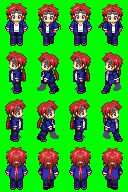

In [ ]:
data_dir = '/content/drive/MyDrive/109_1_AIcourse/img_folder/img/'
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
test = cv2.imread(data_dir+'reno.png')
cv2_imshow(test)

(192, 128, 3)


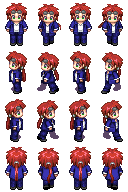

In [ ]:
def alpha2white(img):
    sp=img.shape
    width=sp[0]
    height=sp[1]
    for yh in range(height):
        for xw in range(width):
            color_d=img[xw,yh]
            if(color_d[3]==0):
                img[xw,yh]=[255,255,255,255]
    return img[:,:,:3]
img=cv2.imread(data_dir+'reno.png',-1)
img_copy=img.copy()
whiteback=alpha2white(img_copy)
print(whiteback.shape)
cv2_imshow(whiteback)
# cv2.imwrite('whiteback.png', whiteback)

In [ ]:
## Testing !!
a = []
h = whiteback.shape[0]
w = whiteback.shape[1]
c = 0
for i in range(4):
  for j in range(4):
    c+=1
    w1 = int(w * (j/4))
    w2 = int(w * ((j+1)/4))
    h1 = int(h * (j/4))
    h2 = int(h * ((j+1)/4))
    cv2.imwrite(f'whiteback{i+1}_{j+1}.png', whiteback[h1:h2,w1:w2,:])

In [ ]:
data_dir = '/content/drive/MyDrive/109_1_AIcourse/img_folder/img/'
data_p = []
for i in os.listdir(data_dir):
  data_p.append(i)
train_p,dev_p = train_test_split(data_p,test_size=0.1, random_state=42)
print(len(train_p))
print(len(dev_p))

In [ ]:
def w2sep_img(img,data_in,data_out):
  img_rgba=cv2.imread(data_in+img,-1)
  img_copy=img_rgba.copy()
  whiteback=alpha2white(img_copy)
  if whiteback.shape[2] != 3:
    stop = True 
  a = []
  h = whiteback.shape[0]
  w = whiteback.shape[1]
  for i in range(4):
    for j in range(4):
      w1 = int(w * (j/4))
      w2 = int(w * ((j+1)/4))
      h1 = int(h * (j/4))
      h2 = int(h * ((j+1)/4))
      cv2.imwrite(f'{data_out}{img.split(".png")[0]}{i+1}_{j+1}.png', whiteback[h1:h2,w1:w2,:])


train_dir = '/content/drive/MyDrive/109_1_AIcourse/train_vae/img/'
dev_dir = '/content/drive/MyDrive/109_1_AIcourse/dev_vae/img/'
for image in train_p:
  w2sep_img(image,data_dir,train_dir)
for image in dev_p:
  w2sep_img(image,data_dir,dev_dir)

### VAE

In [ ]:
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import torchvision

img_width = 28
img_height = 28
bs = 6
img_transform = transforms.Compose([
    transforms.Resize((img_height,img_width)),                                
    transforms.ToTensor()
])

tr_dir = '/content/train_vae'
de_dir = '/content/dev_vae'
train_datasets = datasets.ImageFolder(tr_dir,
                                      img_transform,
                                      )
dev_datasets = datasets.ImageFolder(de_dir,
                                      img_transform
                                      )
train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=bs)
dev_dataloader = torch.utils.data.DataLoader(dev_datasets, batch_size=bs)

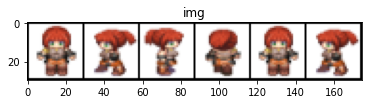

In [ ]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0)) ## 
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

idx = random.randint(0,len(train_dataloader))
for i,(img,_) in enumerate(train_dataloader):
  if i == idx:
    inputs = img
    break
out = torchvision.utils.make_grid(inputs,padding=1)
imshow(out, title='img')

In [ ]:
from tqdm.notebook import tqdm 

latent_dims = 2
num_epochs = 20
bs = 16
capacity = 64
learning_rate = 1e-3
variational_beta = 1
use_gpu = True

train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=bs , shuffle=True)
dev_dataloader = torch.utils.data.DataLoader(dev_datasets, batch_size=bs)

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) 
        self.fc_mu = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)
            
    def forward(self, x):
        # print(x.shape)
        x = F.relu(self.conv1(x))
        # print(x.shape)
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        # print(x.shape)
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        # print(x_mu.shape)
        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*7*7)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=3, kernel_size=4, stride=2, padding=1)
            
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), capacity*2, 7, 7) 
        x = F.relu(self.conv2(x))
        # print(x.shape)
        x = torch.sigmoid(self.conv1(x))
        # print(x.shape)
        return x
    
class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar
    
    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.9).exp_()
            eps = torch.randn_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu
    
def vae_loss(recon_x, x, mu, logvar):

    # print(recon_x.shape,x.shape)
    # print(recon_x.view(-1, 2352).shape, x.view(-1, 2352).shape)
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 2352), x.view(-1, 2352), reduction='sum')
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + variational_beta * kldivergence
    
    
vae = VariationalAutoencoder()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
vae = vae.to(device)

num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)

print('Number of parameters: %d' % num_params)

optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)

Number of parameters: 312455


In [ ]:
# set to training mode
vae.train()
train_loss_avg = []
img_idx = 21
print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    trange = tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc='train')
    for idx,(image_batch, _) in trange:
        # print('asd')
        image_batch = image_batch.to(device)
        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)
        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()    
        train_loss_avg[-1] += loss.item()
        num_batches += 1
        if img_idx == idx:
          origin_img = image_batch.cpu().detach()
          after_img = image_batch_recon.cpu().detach()
    
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))
    origin = torchvision.utils.make_grid(origin_img,padding=2)
    imshow(origin, title='img')
    after = torchvision.utils.make_grid(after_img,padding=2)
    imshow(after, title='img')
# torch.save(model.state_dict(), dataPath+'glove/model.pkl.'+str(epoch))

Output hidden; open in https://colab.research.google.com to view.

Plot Training Curve
--------------------

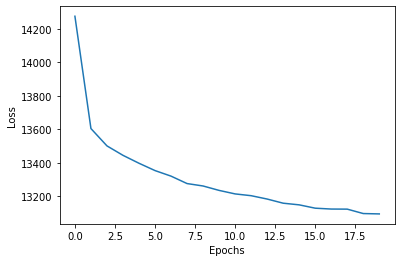

In [ ]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
# set to evaluation mode
vae.eval()

test_loss_avg, num_batches = 0, 0
for image_batch, _ in dev_dataloader:
    
    with torch.no_grad():
    
        image_batch = image_batch.to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)

        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)

        test_loss_avg += loss.item()
        num_batches += 1
test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

average reconstruction error: 13203.805884


Visualize Reconstructions
--------------------------

Original images


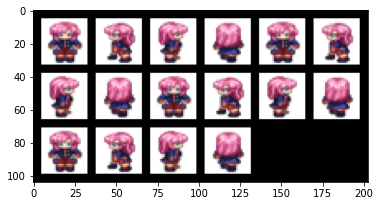

VAE reconstruction:


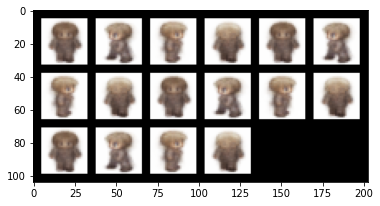

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()
import torchvision.utils
vae.eval()

def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():
    
        images = images.to(device)
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images, 6, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()


idx = random.randint(0,len(dev_dataloader))
for i,(img,_) in enumerate(dev_dataloader):
  if i == idx:
    dev_inputs1 = img
    dev_inputs2 = img
    break

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(dev_inputs1,6,5))
plt.show()

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
visualise_output(dev_inputs2, vae)

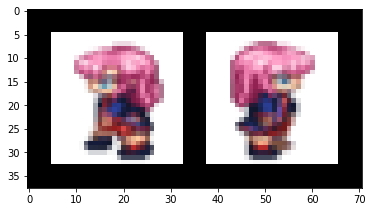

In [ ]:
x_one = dev_inputs1[1:2]
x_two = dev_inputs1[2:3]
show_image(torchvision.utils.make_grid(dev_inputs2[1:3],6,5))

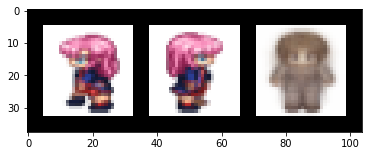

In [ ]:
def generate_half(model,x_one,x_two):
  x_one = x_one.to(device)
  x_two = x_two.to(device)
  h_1,_ = model.encoder(x_one)
  h_2,_ = model.encoder(x_two)
  mu_1 = h_1[:,:28]
  mu_2 = h_1[:,:28]
  mu = (mu_1 - mu_2)/2
  logvar_1 = h_1[:,28:]
  z = model.latent_sample(mu,logvar_1)
  g_img = model.decoder(z)
  return g_img

d_imgs = []
g_img = generate_half(vae,x_one,x_two)

d_imgs.append(x_one[0].cpu().data)
d_imgs.append(x_two[0].cpu().data)
d_imgs.append(g_img[0].cpu().data)
show_image(torchvision.utils.make_grid(d_imgs,6,5))

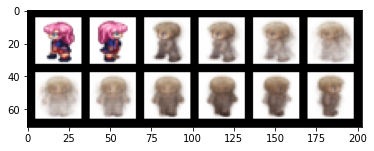

In [ ]:
def g_with_interpolation(model,x_one,x_two,alpha):
  x_one = x_one.to(device)
  x_two = x_two.to(device)
  h_1,_ = model.encoder(x_one)
  h_2,_ = model.encoder(x_two)
  mu_1 = h_1[:,:28]
  logvar_1 = h_1[:,28:]
  mu_2 = h_2[:,:28]
  logvar_2 = h_2[:,28:]

  mu = (1-alpha) *mu_1 + alpha * mu_2
  logvar = (1-alpha) *logvar_1 + alpha * logvar_2
  
  z = model.latent_sample(mu,logvar_2)
  g_img = model.decoder(z)
  return g_img[0].cpu().data

g_imgs = []

g_imgs.append(x_one[0].cpu().data)
g_imgs.append(x_two[0].cpu().data)
for a in torch.arange(0.0,1.0,0.1):
  g_imgs.append(g_with_interpolation(vae,x_one,x_two,a))

show_image(torchvision.utils.make_grid(g_imgs,6,5))